# Task 5

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Defining the function to perform matrix factorization

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def factorize(A, r, device):
    A = A.to(device)
    #randomly initializing W and H
    W = torch.randn(A.shape[0], r, requires_grad=True, device=device)
    H = torch.randn(r, A.shape[1], requires_grad=True, device=device)
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    diff_matrix = torch.mm(W, H) - A
    diff_vector = diff_matrix[mask]
    prev_loss = torch.norm(diff_vector)+1
    for i in range(1000):
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        if ((prev_loss == loss)):
            break
        prev_loss = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return W, H, loss

Reading the image

In [3]:
import torchvision
img = torchvision.io.read_image("task_4_image.jpeg")
print(img.shape)

torch.Size([3, 1200, 1920])


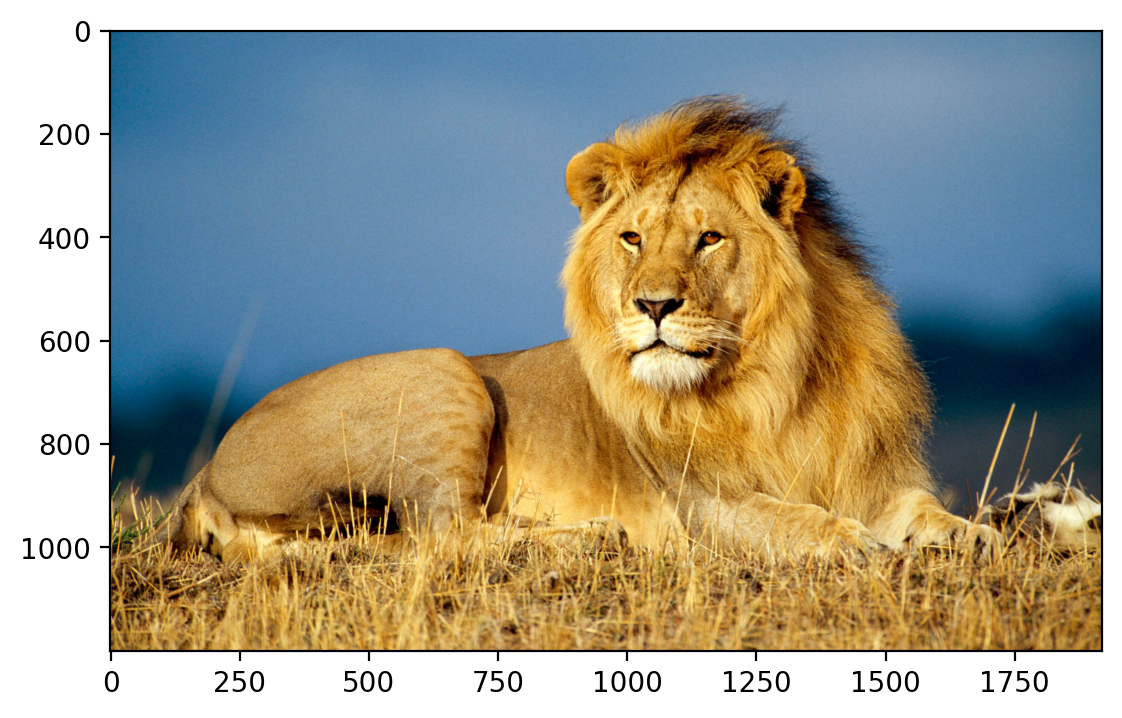

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

Choosing the patchess with approximately single colour, double colour and multi-colour respectively

torch.Size([3, 50, 50])


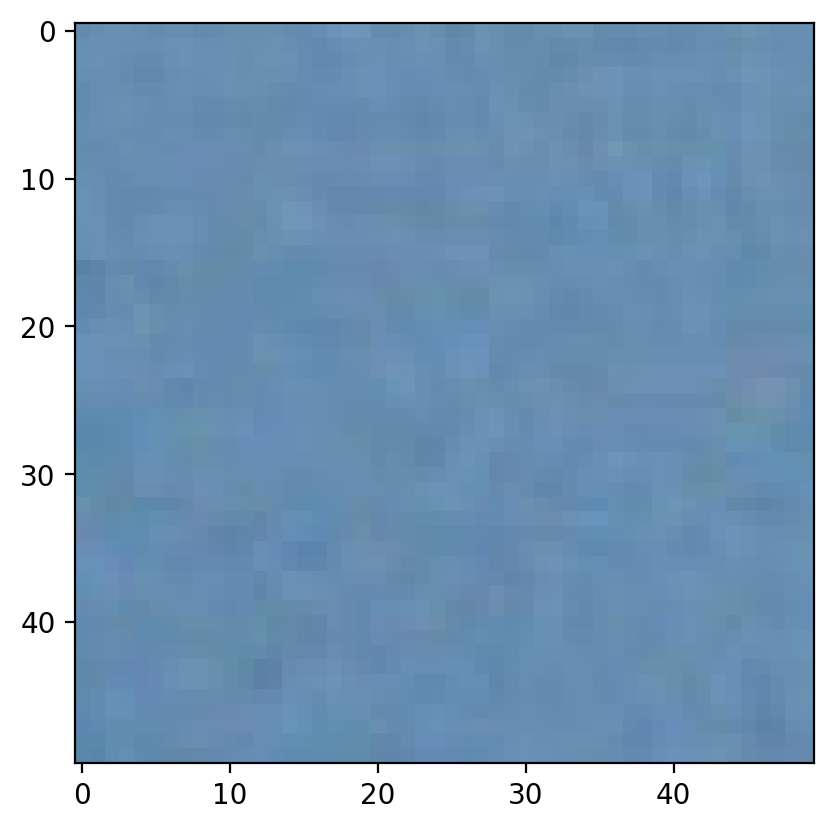

In [9]:
crop0 = torchvision.transforms.functional.crop(img, 400, 500, 50, 50)
print(crop0.shape)
plt.imshow(rearrange(crop0, 'c h w -> h w c').numpy())

torch.Size([3, 50, 50])


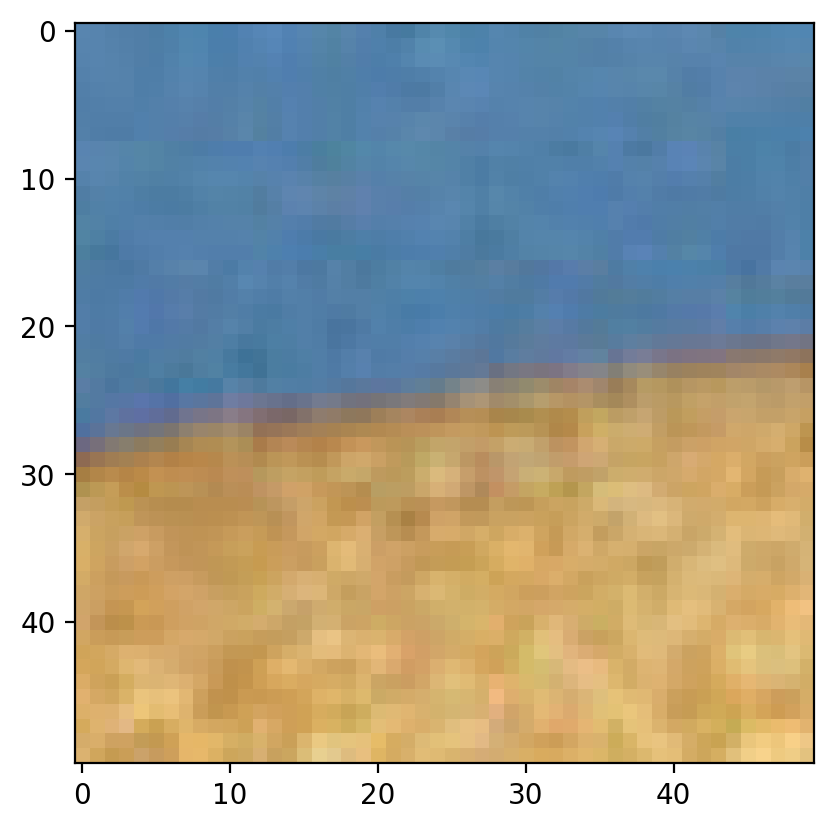

In [10]:
crop1 = torchvision.transforms.functional.crop(img, 600, 500, 50, 50)
print(crop1.shape)
plt.imshow(rearrange(crop1, 'c h w -> h w c').numpy())

torch.Size([3, 50, 50])


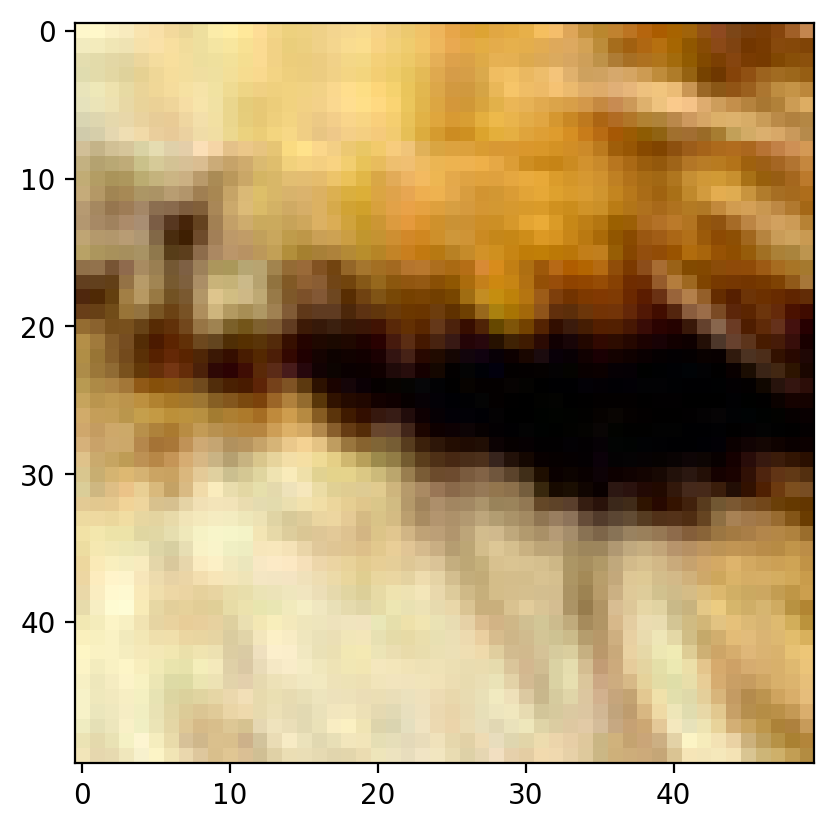

In [16]:
crop2 = torchvision.transforms.functional.crop(img, 600, 1100, 50, 50)
print(crop2.shape)
plt.imshow(rearrange(crop2, 'c h w -> h w c').numpy())

In [18]:
crops = [crop0, crop1, crop2]
r = [5, 10, 25, 50]

In [35]:
recon_imgs = []
for cropped_image in crops:
    for rank in r:
        W0, H0, loss0 = factorize(cropped_image[0], rank, device=device)
        W1, H1, loss1 = factorize(cropped_image[1], rank, device=device)
        W2, H2, loss2 = factorize(cropped_image[2], rank, device=device)
        print("factorization done")
        arr0 = torch.mm(W0, H0).cpu().detach().numpy()
        arr1 = torch.mm(W1, H1).cpu().detach().numpy()
        arr2 = torch.mm(W2, H2).cpu().detach().numpy()
        arr0 = np.clip(arr0, 0, 255)
        arr1 = np.clip(arr1, 0, 255)
        arr2 = np.clip(arr2, 0, 255)
        reimg = torch.Tensor(np.array([arr0, arr1, arr2]))
        recon_imgs.append(reimg)

factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done
factorization done


Defining functions for calculating RMSE and PSNR

In [45]:
def cal_rmse(original_image, reconstructed_image):
    original_image = original_image.numpy().astype(np.float32)
    reconstructed_image = reconstructed_image.numpy().astype(np.float32)

    mse = np.mean((original_image-reconstructed_image)**2)
    rmse = np.sqrt(mse)
    return rmse

def cal_psnr(original_image, reconstructed_img):
    rmse = cal_rmse(original_image, reconstructed_img)
    psnr = 20 * np.log10(255.0/rmse)
    return psnr

In [46]:
rmse = []
psnr = []
for i in range(len(recon_imgs)):
    rmse.append(cal_rmse(crops[i//4], recon_imgs[i]))
    psnr.append(cal_psnr(crops[i//4], recon_imgs[i]))

In [53]:
recon_imgs[0].shape

torch.Size([3, 50, 50])

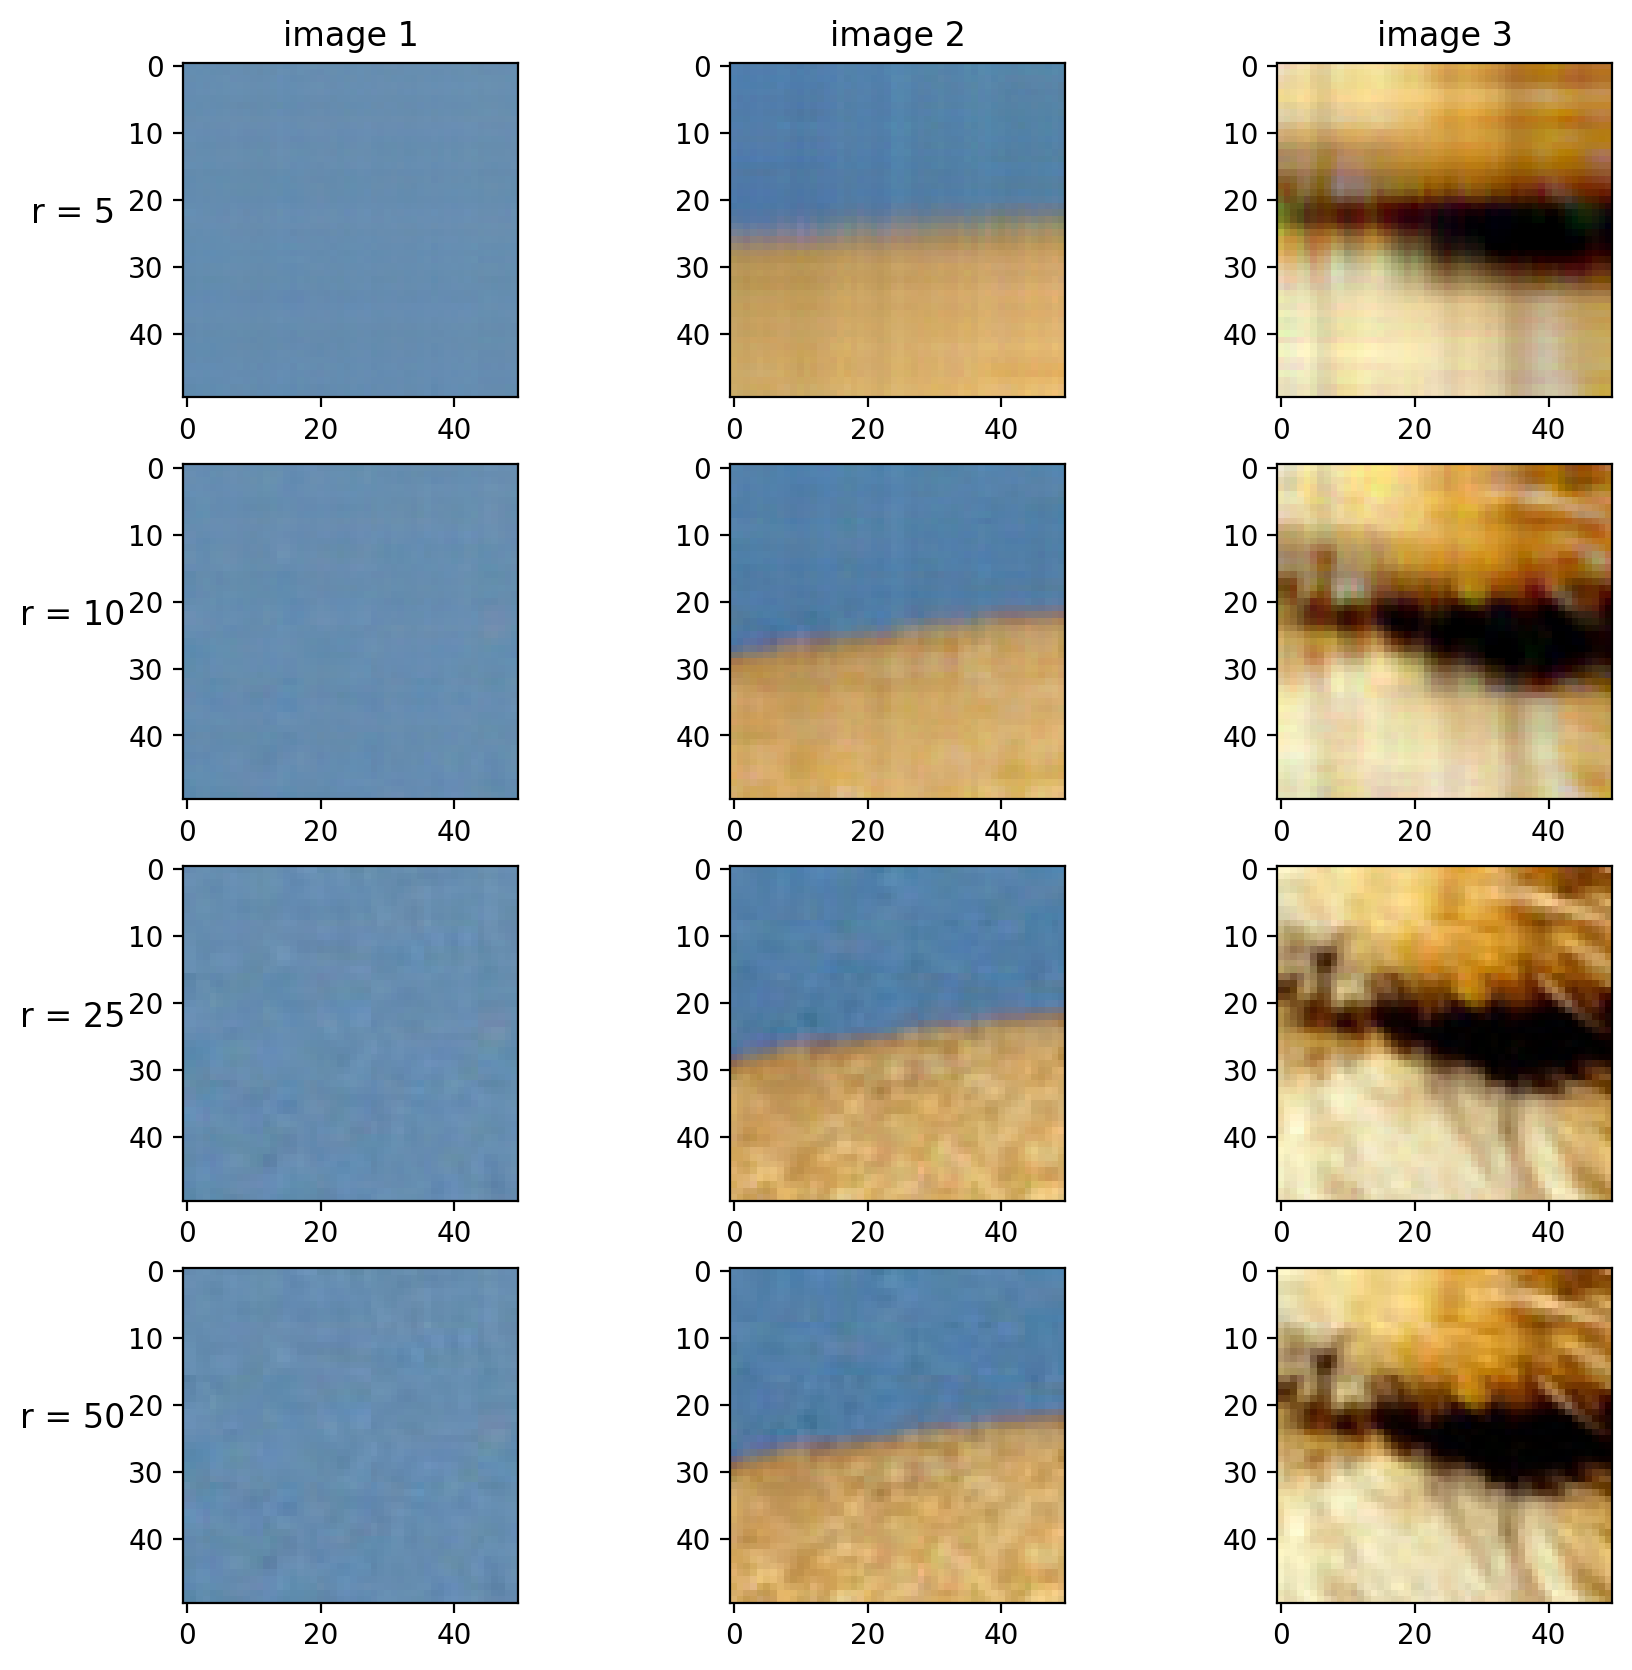

In [87]:
#comparing the reconstructed image with the original image
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
row_labels = ['r = 5', 'r = 10', 'r = 25', 'r = 50']
ax[0][0].set_title("image 1")
ax[0][1].set_title("image 2")
ax[0][2].set_title("image 3")
for i in range(4):
    ax[i][0].set_ylabel(row_labels[i], rotation=0, labelpad=20, fontsize=12)
    for j in range(3):
        ax[i][j].imshow(rearrange(recon_imgs[i+4*j], 'c h w -> h w c').numpy().astype(np.uint8))


In [70]:
rmsepd = []
for i in range(4):
    lin = []
    for j in range(3):
        lin.append(rmse[i+4*j])
    rmsepd.append(lin)

In [88]:
rmsedf = pd.DataFrame(rmsepd, columns=['image 1', 'image 2', 'image 3'], index=['r = 5', 'r = 10', 'r = 25', 'r = 50'])
print("RMSE:")
rmsedf

RMSE:


image 1   image 2    image 3
r = 5   2.986698  9.223326  19.201887
r = 10  2.318517  5.192322  11.946266
r = 25  0.744419  1.027035   1.982693
r = 50  0.126859  0.107259   0.115360

In [89]:
psnrpd = []
for i in range(4):
    lin = []
    for j in range(3):
        lin.append(psnr[i+4*j])
    psnrpd.append(lin)

In [90]:
psnrdf = pd.DataFrame(psnrpd, columns=['image 1', 'image 2', 'image 3'], index=['r = 5', 'r = 10', 'r = 25', 'r = 50'])
print("PSNR:")
psnrdf

PSNR:


image 1    image 2    image 3
r = 5   38.626978  28.833053  22.463925
r = 10  40.826596  33.823571  26.586160
r = 25  50.694452  47.899097  42.185693
r = 50  66.064379  67.522138  66.889687

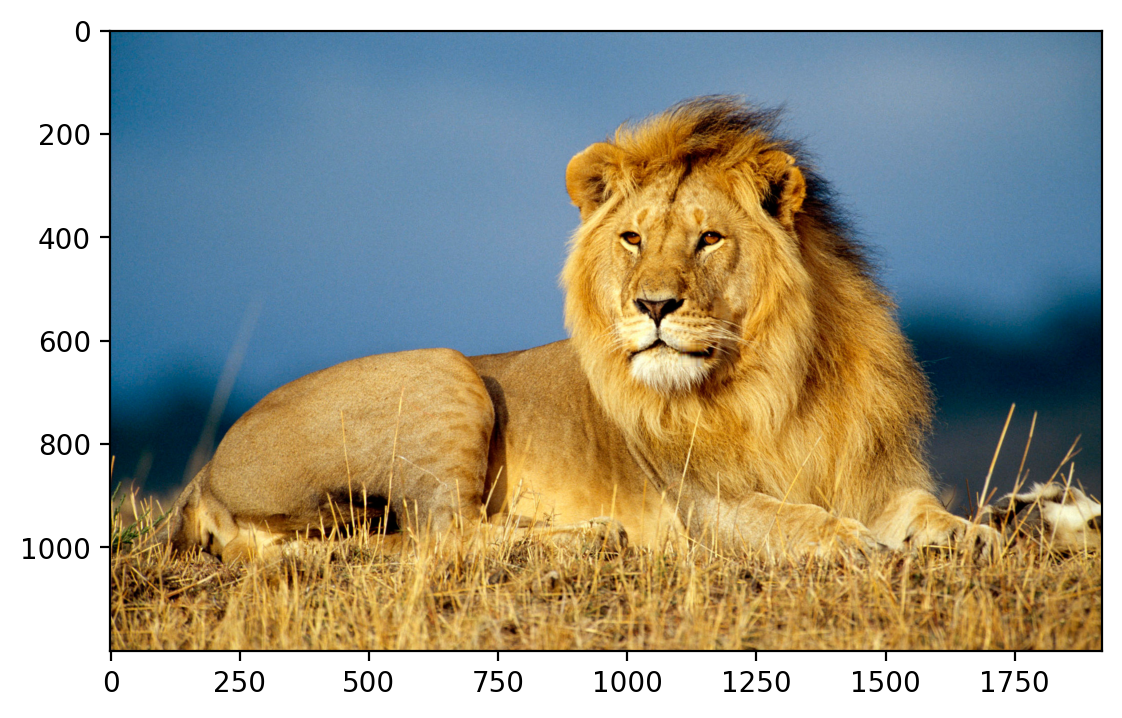

In [97]:
imgclone = img.clone()
patch = recon_imgs[8]
x = 600
y = 1100
imgclone[:, x:x+50, y:y+50] = patch
plt.imshow(rearrange(imgclone, 'c h w -> h w c').numpy().astype(np.uint8))

In [95]:
xcord = [400, 600, 600]
ycord = [500, 500, 1100]
patch_replaced_imgs = []
for i in range(4):
    for j in range(3):
        imgclone = img.clone()
        patch = recon_imgs[i+4*j]
        x = xcord[j]
        y = ycord[j]
        imgclone[:, x:x+50, y:y+50] = patch
        patch_replaced_imgs.append(imgclone)

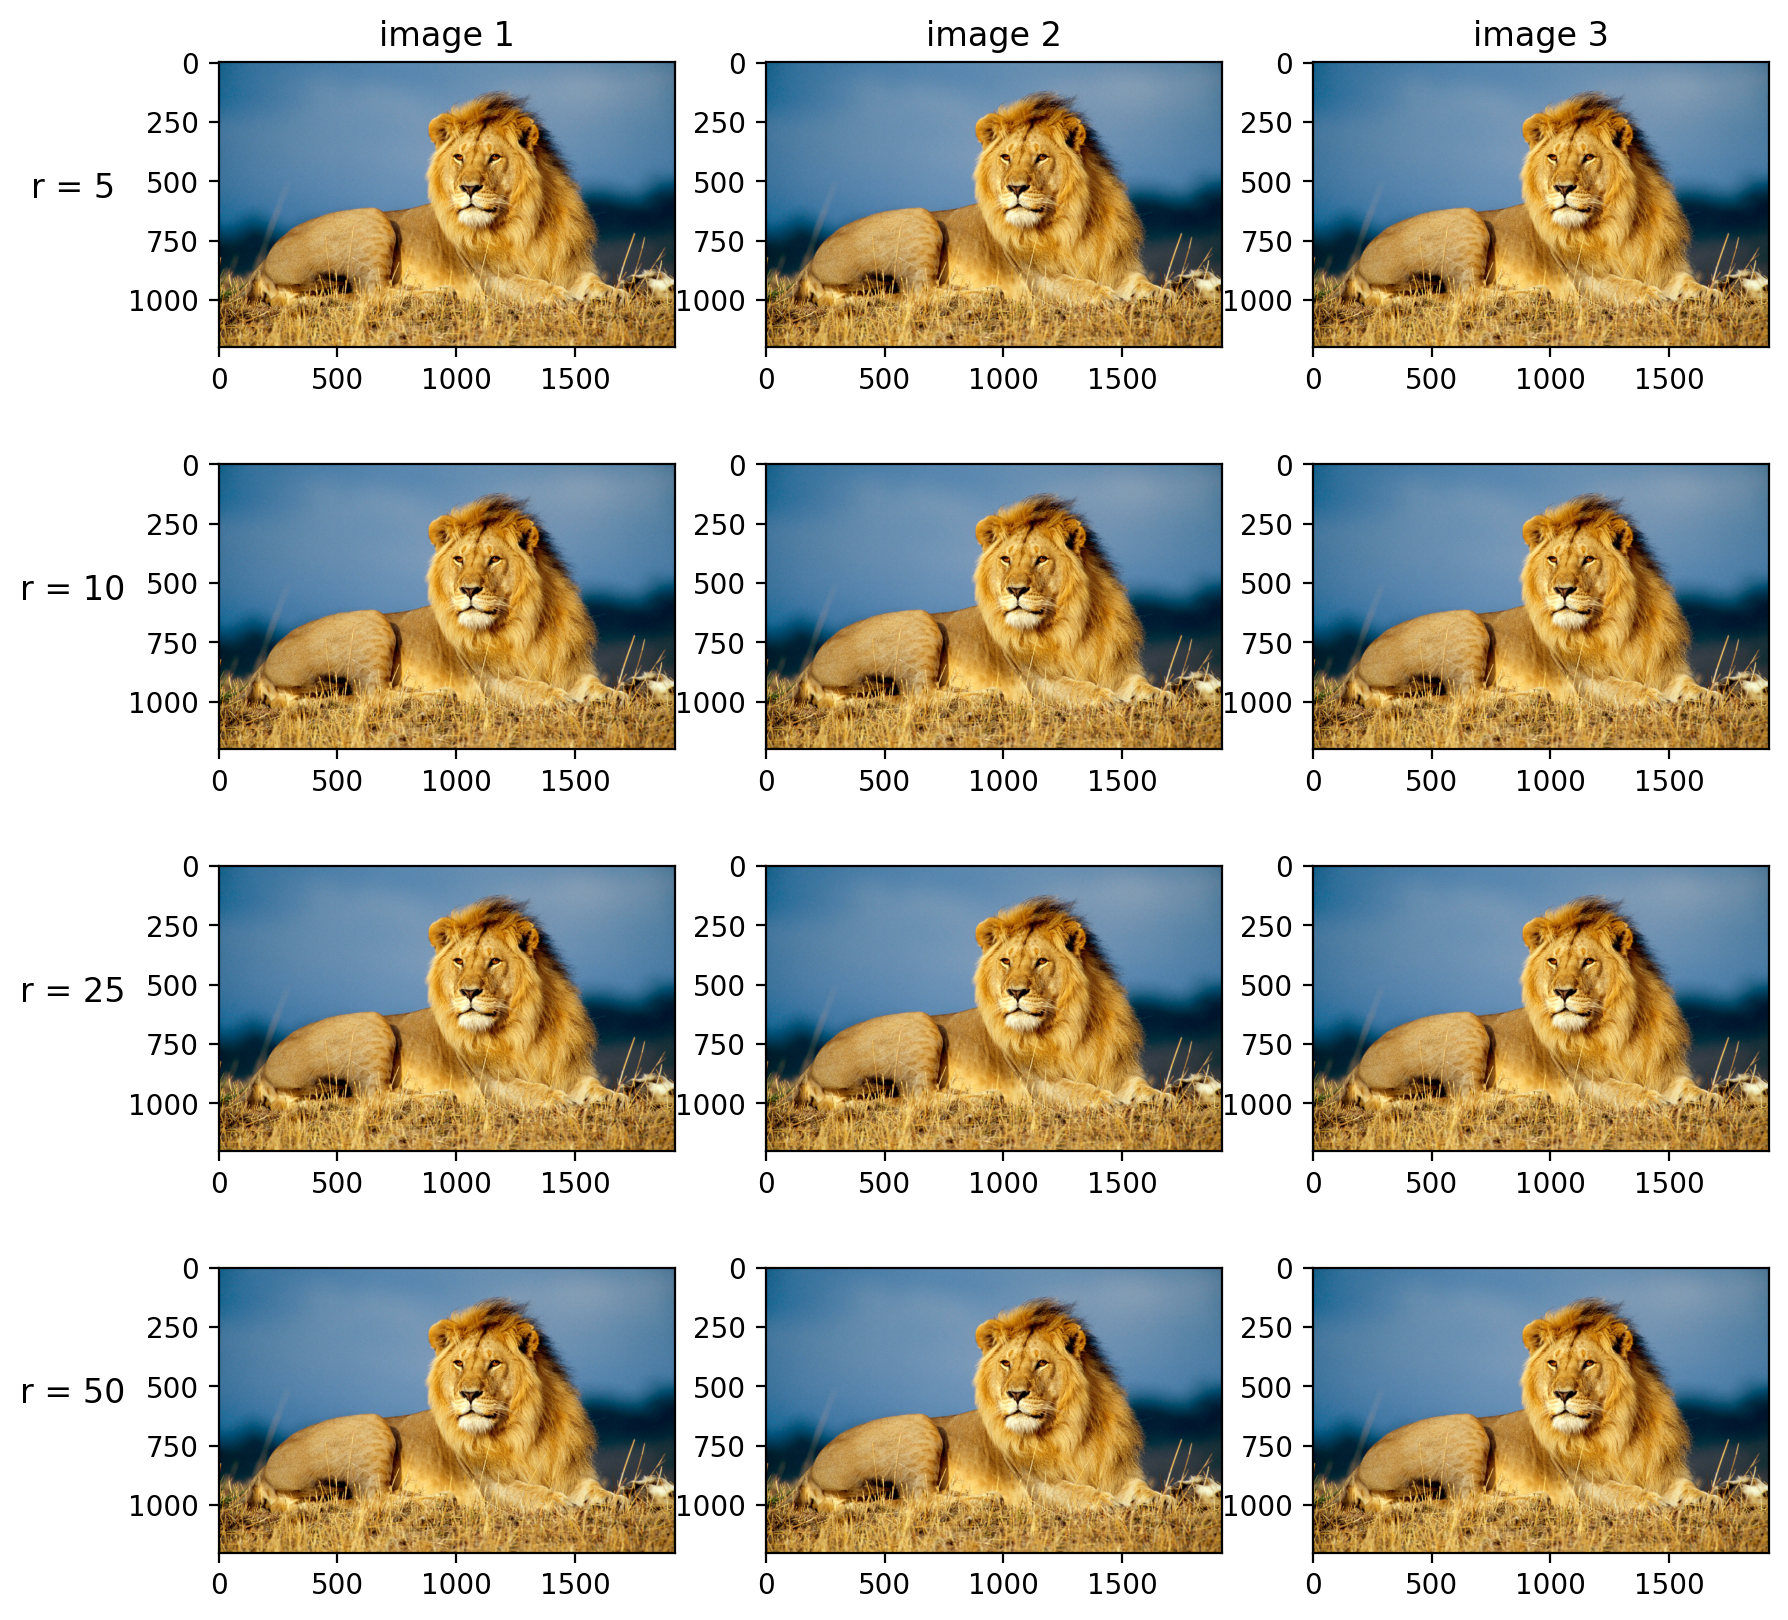

In [96]:
#comparing the reconstructed image with the original image
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
row_labels = ['r = 5', 'r = 10', 'r = 25', 'r = 50']
ax[0][0].set_title("image 1")
ax[0][1].set_title("image 2")
ax[0][2].set_title("image 3")
for i in range(4):
    ax[i][0].set_ylabel(row_labels[i], rotation=0, labelpad=20, fontsize=12)
    for j in range(3):
        ax[i][j].imshow(rearrange(patch_replaced_imgs[i+4*j], 'c h w -> h w c').numpy().astype(np.uint8))
